In [1]:
import jax
import numpy as np
from qiskit_dynamics.array import wrap, Array
from qiskit_dynamics.pulse import InstructionToSignals
from scipy.optimize import minimize

from qiskit.scheduler.config import ScheduleConfig
from qiskit.scheduler.schedule_circuit import schedule_circuit
from qiskit import schedule as build_schedule
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver
from qiskit import QuantumCircuit
from qiskit.pulse import Schedule

from casq import PulseCircuit, PulseSolver, PulseBackendProperties
from casq.common import initialize_jax
from casq.gates import GaussianSquarePulseGate

initialize_jax()
value_and_grad = wrap(jax.value_and_grad, decorator=True)
jit = wrap(jax.jit, decorator=True)

# from jax.config import config
# config.update('jax_disable_jit', True)


In [8]:
solver = PulseSolver.from_backend("ibmq_manila", [0])
backend = solver._backend
backend_props = PulseBackendProperties(backend)


In [9]:
def build_circuit(params):
    duration = 230
    amplitude = 1
    sigma, width = params
    x = GaussianSquarePulseGate(duration, amplitude, sigma, width, jax=True, name="x")
    # return x.schedule(qubit=0, backend=backend, measured=True, discretized=False)
    return PulseCircuit.from_pulse(x, backend, 0)

def build_regular_circuit(params):
    circuit = QuantumCircuit(1, 1)
    circuit.x(0)
    circuit.measure([0], [0])
    return circuit


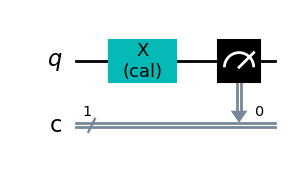

In [10]:
build_circuit([10.,10.]).draw("mpl")


In [11]:
schedule = GaussianSquarePulseGate(230, 1, 10, 10, jax=True, name="x").schedule(0, backend, measured=True)
print(schedule.instructions)


((0, Play(x(duration=230, sigma=10, width=10, amp=1, angle=0, name='x'), DriveChannel(0), name='x')), (230, Acquire(22400, AcquireChannel(0), MemorySlot(0))), (230, Play(GaussianSquare(duration=22400, sigma=64, width=22144, amp=0.28, angle=-0.35601146681917717, name='M_m0'), MeasureChannel(0), name='M_m0')), (22630, TimeBlockade(1680, AcquireChannel(0))), (22630, Delay(1680, MeasureChannel(0))))


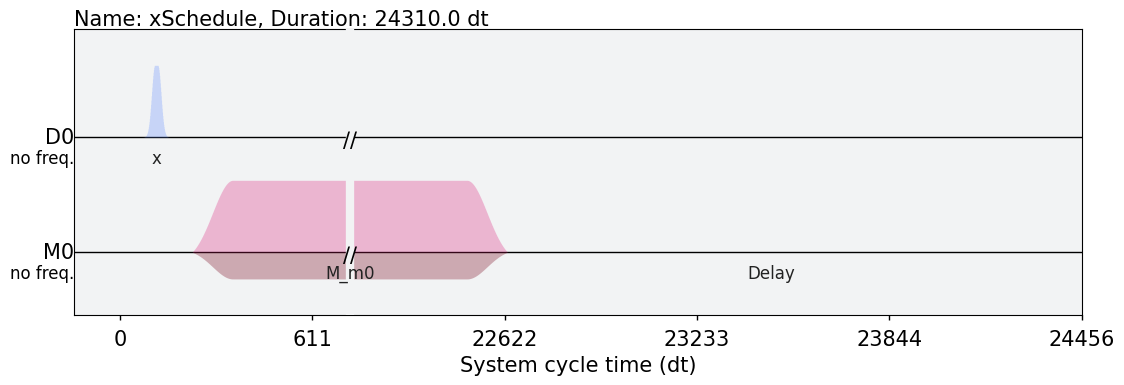

In [12]:
schedule.draw()


In [13]:
def objective1(params):
    solution = solver.solve(
        run_input=build_circuit(params),
        method="jax_odeint",
        atol=1e-8,
        rtol=1e-8
    )
    print(X_op)
    u = Array(solution.statevectors[-1].from_label("0"))
    print(u)
    f = np.abs(np.sum(X_op * u))**2 / 4.
    print(f)
    v = 1. - f
    print(1. - f)
    return v.data

jit_grad_obj1 = jit(value_and_grad(objective1))


In [14]:
# objective1(np.array([10., 10.]))
# value_and_grad(objective1)(np.array([10., 10.]))
jit_grad_obj1(np.array([10., 10.]))

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(complex128[3])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(complex128[3])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(complex128[3])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(complex128[3]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x1540a30e0>, in_tracers=(Traced<ShapedArray(complex128[1,3]):JaxprTrace(level=2/0)>,), out_tracer_refs=[<weakref at 0x1543aa570; to 'JaxprTracer' at 0x1543ab1f0>], out_avals=[ShapedArray(complex128[3])], primitive=squeeze, params={'dimensions': (0,)}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x1544a9970>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:
build_circuit(np.array([10., 10.])).draw()


In [ ]:
%%time
initial_params = np.array([10, 10])
opt_results = minimize(fun=jit_grad_obj1, x0=initial_params, jac=True, method="BFGS")
print(opt_results.message)
print(f"Optimized Sigma is {opt_results.x[0]} and Width is {opt_results.x[1]}")
print('Number of function evaluations: ' + str(opt_results.nfev))
print('Function value: ' + str(opt_results.fun))
